In [32]:
import pandas as pd
import math
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

SHUFFLE_BUFFER = 500
BATCH_SIZE = 36
epochs = 50

In [3]:
data = pd.read_csv('Skyserver_SQL2_27_2018 6_51_39 PM.csv')
print(set(data.columns.to_list())-{'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift', 'class'})
data = pd.DataFrame({
	x: data[x] for x in ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift', 'class']
})


{'specobjid', 'run', 'field', 'mjd', 'plate', 'fiberid', 'objid', 'camcol', 'rerun'}


In [4]:
data.head()
cleaned_data = pd.get_dummies(data, columns=['class'])
cleaned_data.head()

,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,-0.000009,0,0,1
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,-0.000055,0,0,1
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0.123111,1,0,0
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,-0.000111,0,0,1
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,0.000590,0,0,1


In [5]:
def z_score_normalize(df:pd.DataFrame):
	return (df-df.mean())/df.std()

def replace_cols(df1, df2, columns):
	for x in columns:
		df1[x] = df2[x]
	return df1

scaled_data = replace_cols(z_score_normalize(cleaned_data), cleaned_data, [x for x in cleaned_data if "class" in x])

for x in scaled_data:
	if 'class' in x:
		scaled_data[x].replace({1: 0.9, 0: 0.1}, inplace=True)
scaled_data.head()

,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR
0,0.167450,-0.584893,1.031435,-0.348542,-0.837238,-0.946010,-0.995292,-0.369713,0.1,0.1,0.9
1,0.168853,-0.583085,0.052428,-0.166524,-0.154148,-0.082640,-0.026042,-0.369831,0.1,0.1,0.9
2,0.170566,-0.583446,0.921522,0.867050,0.593124,0.441179,0.314512,-0.053024,0.9,0.1,0.1
3,0.174549,-0.586471,-1.030579,-0.813587,-0.636660,-0.526578,-0.430900,-0.369974,0.1,0.1,0.9
4,0.174816,-0.584383,-1.290168,-1.172461,-0.376744,-0.025100,0.158269,-0.368171,0.1,0.1,0.9


In [6]:
data = scaled_data

TRAINING_SIZE = math.floor(0.5*len(data))
TEST_SIZE = math.floor(0.3*len(data))
EVALUATION_SIZE = math.floor(0.2*len(data))

indices = (TRAINING_SIZE, TRAINING_SIZE+TEST_SIZE, TRAINING_SIZE+TEST_SIZE+EVALUATION_SIZE)
inputs = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']
outputs = ['class_GALAXY','class_QSO','class_STAR']

training = data[0:indices[0]]
test = data[indices[0]:indices[1]]
evaluation = data[indices[1]:indices[2]]
professor = {
	"training": {
		"questions": training[inputs],
		"answers": training[outputs]
	},
	"test": {
		"questions": test[inputs],
		"answers": test[outputs]
	},
	"evaluation": {
		"questions": evaluation[inputs],
		"answers": evaluation[outputs]
	}
}

In [33]:
def create_model(l):
    normalizer = keras.layers.Normalization(axis=-1)
    normalizer.adapt(data[['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']])

    m = keras.Sequential(
        [
            tf.keras.layers.Dense(40, activation='relu', input_dim=8),  # input shape required
            tf.keras.layers.Dense(40, activation='relu'),
            tf.keras.layers.Dense(20, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')
        ]
    )

    m.compile(
        optimizer='sgd',
        loss=loss_fn,
        metrics=['accuracy']
    )
    return m
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
model = create_model(loss_fn)
history = model.fit(professor['training']['questions'], professor['training']['answers'], validation_data=(professor['test']['questions'], professor['test']['answers']), epochs=epochs, batch_size=BATCH_SIZE)

Epoch 1/50
139/139 [==============================] - 3s 12ms/step - loss: 0.6843 - accuracy: 0.4926 - val_loss: 0.6541 - val_accuracy: 0.5230

/Users/jonathensundy/Library/Caches/pypoetry/virtualenvs/supervised-nn-M4NFOCcW-py3.8/lib/python3.8/site-packages/keras/backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
/Users/jonathensundy/Library/Caches/pypoetry/virtualenvs/supervised-nn-M4NFOCcW-py3.8/lib/python3.8/site-packages/keras/backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


In [34]:
model.evaluate(professor["evaluation"]["questions"], professor['evaluation']['answers'])

63/63 [==============================] - 0s 3ms/step - loss: 0.3927 - accuracy: 0.9440


[0.3927179276943207, 0.9440000057220459]

Text(0.5, 1.0, 'Training and Validation Accuracy')

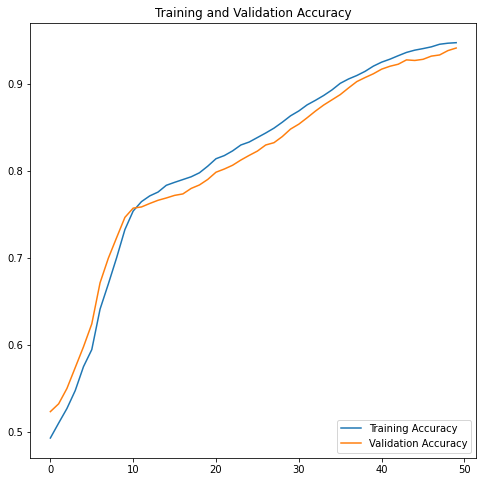

In [36]:
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history["accuracy"], label='Training Accuracy')
plt.plot(epochs_range, history.history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# plt.savefig('graph/accuracy.png')

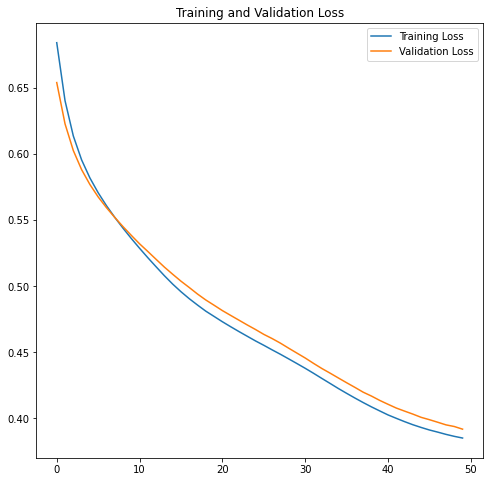

In [37]:
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history["loss"], label='Training Loss')
plt.plot(epochs_range, history.history["val_loss"], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
lis_error = []
dataframe = training.copy()

for i in range(len(professor['training']['answers'])):
    x = professor['training']['questions'].iloc[i]
    # x = tf.expand_dims(x, -1)
    prediction = model(x, training=False)
    y = professor['training']['answers'].iloc[i]
    y = np.asarray(y).astype('float32').reshape((1,-1))
    loss = loss_fn(y, prediction)
    lis_error.append(loss.numpy())

AttributeError: 'tuple' object has no attribute 'rank'

In [12]:
dataframe = training.copy()
dataframe['loss'] = lis_error
dataframe = dataframe.sort_values(by='loss', ascending=True)
dataframe = dataframe.drop(columns='loss')

In [13]:
professor['training']['questions'] = dataframe[inputs]
professor['training']['answers'] = dataframe[outputs]

In [14]:
def append_history_list(current_history):
    for key in current_history:
        if key in histories.keys():
            histories[key].extend(current_history[key])
        else:
            histories[key] = current_history[key]

In [28]:
import math
histories = {}
model = create_model(loss_fn)

step_frequency = 5
initial_percentage = .5
exponential_factor = 1.5

buckets = math.floor(epochs/step_frequency)
total_data = training.shape[0]
initial_data_count = math.floor(initial_percentage*total_data)
curr_percentage = 0.5
for i in range(0, buckets):
    curr_percentage = (i+1)/buckets
    # curr_percentage = min(curr_percentage*exponential_factor, 1)
    data_left = total_data-initial_data_count
    offset_data_count = math.floor(curr_percentage*data_left)

    upper_bound = initial_data_count + offset_data_count
    x = professor['training']['questions'][0: upper_bound]
    y = professor['training']['answers'][0: upper_bound]
    history = model.fit(x, y, validation_data=(professor['test']['questions'], professor['test']['answers']), epochs=step_frequency, batch_size=BATCH_SIZE)
    hist = history.history
    for key in hist:
        if key in histories.keys():
            histories[key].extend(hist[key])
        else:
            histories[key] = hist[key]

Epoch 1/5
77/77 [==============================] - 2s 11ms/step - loss: 0.6260 - accuracy: 0.5433 - val_loss: 0.6341 - val_accuracy: 0.5717
Epoch 2/5
77/77 [==============================] - 0s 3ms/step - loss: 0.5959 - accuracy: 0.5938 - val_loss: 0.6154 - val_accuracy: 0.6030
Epoch 3/5
77/77 [==============================] - 0s 4ms/step - loss: 0

/Users/jonathensundy/Library/Caches/pypoetry/virtualenvs/supervised-nn-M4NFOCcW-py3.8/lib/python3.8/site-packages/keras/backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
/Users/jonathensundy/Library/Caches/pypoetry/virtualenvs/supervised-nn-M4NFOCcW-py3.8/lib/python3.8/site-packages/keras/backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
/Users/jonathensundy/Library/Caches/pypoetry/virtualenvs/supervised-nn-M4NFOCcW-py3.8/lib/python3.8/site-packages/keras/backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represen

Text(0.5, 1.0, 'Training and Validation Accuracy')

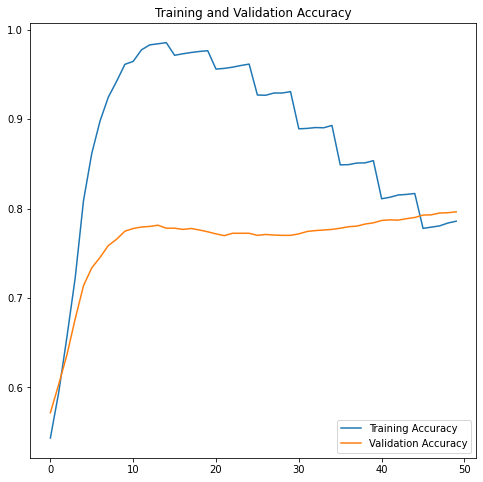

In [29]:
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, histories["accuracy"], label='Training Accuracy')
plt.plot(epochs_range, histories["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# plt.savefig('graph/accuracy.png')

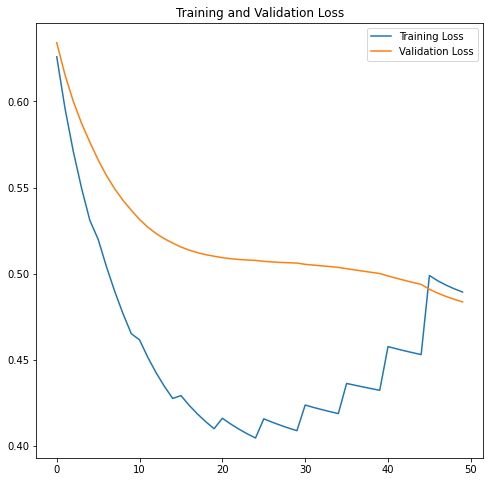

In [30]:
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, histories["loss"], label='Training Loss')
plt.plot(epochs_range, histories["val_loss"], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 8)                 17        
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 81        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 30        
Total params: 128
Trainable params: 111
Non-trainable params: 17
_________________________________________________________________


In [19]:
evaluation.head(5)

,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR
8000,0.190349,-0.599724,-0.079026,-0.204305,-0.154887,-0.110684,-0.030056,-0.370001,0.1,0.1,0.9
8001,0.188651,-0.598305,0.745707,0.702019,0.629892,0.602372,0.601848,-0.367239,0.1,0.1,0.9
8002,0.190667,-0.604786,1.004693,0.648648,0.312791,0.092810,-0.032583,-0.091988,0.9,0.1,0.1
8003,0.191552,-0.603357,0.394077,1.518491,1.645257,1.595851,1.568480,3.531147,0.1,0.9,0.1
8004,0.191230,-0.598623,-1.215336,-1.586335,-1.722162,-1.761351,-1.850619,-0.164494,0.9,0.1,0.1


In [20]:
model.__call__(professor['evaluation']['questions'].head(5))

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.38469008, 0.06992888, 0.54538107],
       [0.4919258 , 0.05833773, 0.44973654],
       [0.9384783 , 0.01772762, 0.04379404],
       [0.01989019, 0.9770757 , 0.00303412],
       [0.886305  , 0.01501032, 0.09868469]], dtype=float32)>